In [1]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from scipy import spatial
from datetime import datetime
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra

from collections import Counter, defaultdict

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/mjoppich/.local/lib/python3.6/site-packages', '/home/mjoppich/.local/lib/python3.6/site-packages/mpld3-0.3.1.dev1-py3.6.egg', '/home/mjoppich/.local/lib/python3.6/site-packages/opennre-0.1-py3.6.egg', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/tf_unet-0.1.1-py3.6.egg', '/mnt/d/PythonCGI/jupyter_micropython_kernel', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../']


/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:144: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1

In [2]:
imze = IMZMLExtract("/mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML")

Opening regions file for /mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML


Brief interrupt: Similarity by Ralf via number of diff peaks

In [ ]:
def calc_similarity( mat ):
    
    bar = progressbar.ProgressBar()
    
    elems = mat.shape[0]*mat.shape[1]
    
    result = np.zeros((elems, elems))
    
    meanMat = np.zeros((elems, elems))
    stdMat = np.zeros((elems, elems))
        
    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mat.shape[0])):
        for j in range(0, mat.shape[1]):
            idxI = i*mat.shape[1] + j
            matIJ = mat[i,j,:]
            
            for k in range(0, mat.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mat.shape[1] + l
                    matKL = mat[k,l,:]
                    
                    if idxJ == idxI:
                        result[idxI, idxJ] = len(matIJ)
                        continue
                    
                    if idxJ < idxJ:
                        continue
                        
                    fcs = (matIJ+0.1) / (matKL+0.1)
                    #fcs = sorted(fcs)
                    
                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)
                    
                    meanMat[idxI, idxJ] = meanFCs
                    stdMat[idxI, idxJ] = stdFCs
                    
                    maxFC = meanFCs + 2*stdFCs
                    minFC = meanFCs - 2*stdFCs
                    
                    sims = len([x for x in fcs if minFC <= x <= maxFC])
                        
                    result[idxI, idxJ] = sims
                    result[idxJ, idxI] = sims
                    
    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                    
    return result, meanMat, stdMat
            
            

In [3]:
spectra_orig = imze.get_region_array(0, makeNullLine=True)
spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")
spectra = imze.normalize_region_array(spectra_intra, normalize="inter_median")

Found region 0 with shape (45, 59, 17900)
I0706 20:27:40.279707 139942458099520 segment.py:2755] Found region 0 with shape (45, 59, 17900)
I0706 20:27:43.569521 139942458099520 segment.py:2469] Collecting fold changes
Got a total of 47524500 fold changes
I0706 20:28:22.569226 139942458099520 segment.py:2480] Got a total of 47524500 fold changes
Median elements [23762250]
I0706 20:28:24.982776 139942458099520 segment.py:2489] Median elements [23762250]
Median elements
I0706 20:28:26.108486 139942458099520 segment.py:2502] Median elements
Global Median 0.96164
I0706 20:28:26.110058 139942458099520 segment.py:2507] Global Median 0.96164


In [4]:
global_fcs = Counter()
scalingFactor = 1
bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

fcMasses = set()
fcMassesCounter = Counter()
masses2fcs = defaultdict(list)

for k in bar(range(spectra.shape[0])):
    for l in range(spectra.shape[1]):
        
        iidx = k*spectra.shape[1] + l

        for i in range(spectra.shape[0]):
            for j in range(spectra.shape[1]):
                
                jidx = i*spectra.shape[1] + j
                
                if iidx < jidx:
                    continue
                
                if k==i and j==l:
                    continue

                fcs = np.log( (spectra[i][j]+(1.0/scalingFactor)) / (spectra[k][l] +(1.0/scalingFactor)) )
                
                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)
                
                maxFC = meanFCs + 4.5*stdFCs
                minFC = meanFCs - 4.5*stdFCs
                    
                sims = np.zeros((len(fcs),))
                
                for i, x in enumerate(fcs):
                    if x < minFC or x > maxFC:
                        sims[i] = 1
                        
                        fcMass = imze.mzValues[i]
                        
                        masses2fcs[fcMass].append(x)
                        fcMassesCounter[fcMass] += 1
                        fcMasses.add(x)



                

|##########################################################| 100% Time: 0:06:39


In [5]:
fcMassesCounter.most_common(20)

[(3451.8561444883712, 53597),
 (3450.3470112750474, 46116),
 (3453.3652777016955, 43008),
 (6270.916986978072, 34514),
 (6269.407853764747, 33563),
 (6642.163757455837, 31261),
 (6218.097324511723, 29845),
 (6640.654624242514, 26946),
 (6216.588191298399, 24934),
 (6643.672890669162, 24131),
 (6219.606457725047, 22971),
 (6267.898720551423, 21690),
 (6272.426120191396, 19604),
 (8558.762938377637, 18899),
 (8557.253805164311, 17862),
 (8444.068814164992, 15858),
 (8560.27207159096, 15648),
 (3454.87441091502, 15140),
 (6221.1155909383715, 14240),
 (3448.837878061723, 13389)]

In [6]:
len(masses2fcs[3451.8561444883712])

53597

In [7]:
len(masses2fcs)

3860

In [ ]:
for x,y in fcMassesCounter.most_common(50)[30:]:
    spec.mass_heatmap(x)

In [8]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)[20:]]
len(mcmasses)

3840

In [9]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])

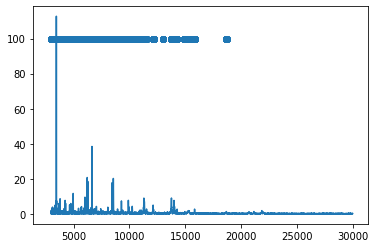

In [10]:
plt.plot(imze.mzValues, spectra[0][0])
plt.scatter(imze.mzValues[fcIndices], [100]*len(fcIndices))

In [11]:
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

In [12]:
spec = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [13]:
spec.calculate_similarity(mode="spectra")

2020-07-06 20:35:10,930  SpectraRegion  INFO: Creating C++ obj
I0706 20:35:10.930484 139942458099520 segment.py:809] Creating C++ obj
2020-07-06 20:35:10,931  SpectraRegion  INFO: 3840 (45, 59, 3840)
I0706 20:35:10.931874 139942458099520 segment.py:810] 3840 (45, 59, 3840)
2020-07-06 20:35:10,933  SpectraRegion  INFO: dimensions 3840
I0706 20:35:10.933110 139942458099520 segment.py:820] dimensions 3840
2020-07-06 20:35:10,935  SpectraRegion  INFO: input dimensions (45, 59, 3840)
I0706 20:35:10.935040 139942458099520 segment.py:821] input dimensions (45, 59, 3840)
2020-07-06 20:35:10,939  SpectraRegion  INFO: Switching to dot mode
I0706 20:35:10.939177 139942458099520 segment.py:824] Switching to dot mode
2020-07-06 20:35:11,111  SpectraRegion  INFO: Starting calc similarity c++
I0706 20:35:11.111216 139942458099520 segment.py:830] Starting calc similarity c++


3840


2020-07-06 20:35:17,190  SpectraRegion  INFO: outclust dimensions (2655, 2655)
I0706 20:35:17.190958 139942458099520 segment.py:835] outclust dimensions (2655, 2655)


array([[0.9999999 , 0.9740785 , 0.9681952 , ..., 0.87017316, 0.88224226,
        0.88643634],
       [0.9740785 , 0.99999994, 0.9774095 , ..., 0.9006153 , 0.9132539 ,
        0.9167217 ],
       [0.9681952 , 0.9774095 , 0.99999994, ..., 0.9163522 , 0.921091  ,
        0.9292456 ],
       ...,
       [0.87017316, 0.9006153 , 0.9163522 , ..., 1.        , 0.9593117 ,
        0.9627757 ],
       [0.88224226, 0.9132539 , 0.921091  , ..., 0.9593117 , 1.        ,
        0.9656893 ],
       [0.88643634, 0.9167217 , 0.9292456 , ..., 0.9627757 , 0.9656893 ,
        1.0000001 ]], dtype=float32)

In [22]:
spec_full = SpectraRegion(spectra, imze.mzValues, "full_masses")

In [23]:
spec_full.calculate_similarity(mode="spectra")

2020-07-06 21:14:23,865  SpectraRegion  INFO: Creating C++ obj
I0706 21:14:23.865145 139942458099520 segment.py:809] Creating C++ obj
2020-07-06 21:14:23,866  SpectraRegion  INFO: 17900 (45, 59, 17900)
I0706 21:14:23.866605 139942458099520 segment.py:810] 17900 (45, 59, 17900)
2020-07-06 21:14:23,868  SpectraRegion  INFO: dimensions 17900
I0706 21:14:23.868377 139942458099520 segment.py:820] dimensions 17900
2020-07-06 21:14:23,870  SpectraRegion  INFO: input dimensions (45, 59, 17900)
I0706 21:14:23.870105 139942458099520 segment.py:821] input dimensions (45, 59, 17900)
2020-07-06 21:14:23,871  SpectraRegion  INFO: Switching to dot mode
I0706 21:14:23.871841 139942458099520 segment.py:824] Switching to dot mode


17900


2020-07-06 21:14:24,177  SpectraRegion  INFO: Starting calc similarity c++
I0706 21:14:24.177450 139942458099520 segment.py:830] Starting calc similarity c++
2020-07-06 21:14:53,443  SpectraRegion  INFO: outclust dimensions (2655, 2655)
I0706 21:14:53.443518 139942458099520 segment.py:835] outclust dimensions (2655, 2655)


array([[1.        , 0.96724546, 0.95772547, ..., 0.78806883, 0.7908129 ,
        0.80429137],
       [0.96724546, 1.        , 0.97715646, ..., 0.85300124, 0.85565996,
        0.8679394 ],
       [0.95772547, 0.97715646, 0.9999999 , ..., 0.87421095, 0.87118435,
        0.88773036],
       ...,
       [0.78806883, 0.85300124, 0.87421095, ..., 1.0000001 , 0.9438676 ,
        0.9509856 ],
       [0.7908129 , 0.85565996, 0.87118435, ..., 0.9438676 , 1.        ,
        0.95205015],
       [0.80429137, 0.8679394 , 0.88773036, ..., 0.9509856 , 0.95205015,
        1.        ]], dtype=float32)

In [ ]:
px2idx = {}
idx2px = defaultdict(set)

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

specidx = np.zeros((spectra.shape[0], spectra.shape[1], 1))
for k in bar(range(spectra.shape[0])):
    for l in range(spectra.shape[1]):
        
        iidx = k*spectra.shape[1] + l
        
        px2idx[(k,l)] = iidx
        
        idx2px[iidx].add((k,l))
        
for x in idx2px:
    if len(idx2px[x]) != 1:
        print(x)

In [ ]:

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

specs = spectra.shape[0] * spectra.shape[1]

specsims = np.zeros((specs, specs))

for k in bar(range(spectra.shape[0])):
    for l in range(spectra.shape[1]):
        
        iIdx = px2idx[(k,l)]
        
        for i in range(spectra.shape[0]):
            for j in range(spectra.shape[1]):
                
                jIdx = px2idx[(i,j)]
                
                if iIdx > jIdx:
                    continue
                
                cosSim = 1 - spatial.distance.cosine(spec.region_array[k,l,:], spec.region_array[i,j,:])
                
                specsims[iIdx, jIdx] = cosSim
                specsims[jIdx, iIdx] = cosSim

In [30]:
spec_full.segment(method="UPGMA", number_of_regions=15)

2020-07-06 21:22:46,875  SpectraRegion  INFO: Calculating clusters
I0706 21:22:46.875091 139942458099520 segment.py:1038] Calculating clusters
2020-07-06 21:22:47,185  SpectraRegion  INFO: Calculating clusters done
I0706 21:22:47.185979 139942458099520 segment.py:1053] Calculating clusters done
2020-07-06 21:22:47,208  SpectraRegion  INFO: Calculating clusters saved
I0706 21:22:47.208056 139942458099520 segment.py:1071] Calculating clusters saved


array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]], dtype=int16)

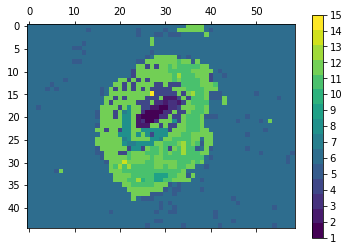

In [31]:
spec_full.plot_segments()

In [32]:
spec_full.filter_clusters(method='remove_singleton')
spec_full.filter_clusters(method='merge_background')
spec_full.filter_clusters(method='remove_islands')

2020-07-06 21:22:51,887  SpectraRegion  INFO: Assigning clusters to background: {6}
I0706 21:22:51.887737 139942458099520 segment.py:1160] Assigning clusters to background: {6}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

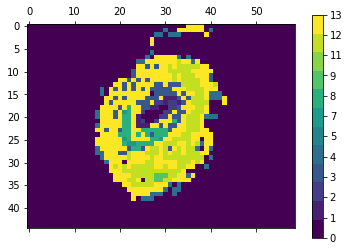

In [33]:
spec_full.plot_segments()

In [37]:
spec_full.consensus_spectra()

2020-07-06 21:31:20,497  SpectraRegion  INFO: Calculating consensus spectra
I0706 21:31:20.497600 139942458099520 segment.py:1214] Calculating consensus spectra
2020-07-06 21:31:20,572  SpectraRegion  INFO: Calculating consensus spectra done
I0706 21:31:20.572191 139942458099520 segment.py:1226] Calculating consensus spectra done


{0: array([0.32852168, 0.32852168, 0.32852168, ..., 0.1385044 , 0.1385044 ,
        0.1385044 ]),
 12: array([0.27898155, 0.27898155, 0.27898155, ..., 0.13699059, 0.13699059,
        0.13699059]),
 5: array([0.3483702 , 0.3483702 , 0.3483702 , ..., 0.15799302, 0.15799302,
        0.15799302]),
 11: array([0.31013767, 0.31013767, 0.31013767, ..., 0.1395962 , 0.1395962 ,
        0.1395962 ]),
 4: array([0.34471673, 0.34471673, 0.34471673, ..., 0.14070436, 0.14070436,
        0.14070436]),
 13: array([0.29159253, 0.29159253, 0.29159253, ..., 0.20933983, 0.20933983,
        0.20933983]),
 2: array([0.40908892, 0.40908892, 0.40908892, ..., 0.1010728 , 0.1010728 ,
        0.1010728 ]),
 3: array([0.37424487, 0.37424487, 0.37424487, ..., 0.11345837, 0.11345837,
        0.11345837]),
 8: array([0.55267137, 0.55267137, 0.55267137, ..., 0.14768409, 0.14768409,
        0.14768409]),
 1: array([0.44625838, 0.44625838, 0.44625838, ..., 0.11572096, 0.11572096,
        0.11572096]),
 7: array([0.4675

In [38]:
spec_full.consensus_similarity()

2020-07-06 21:31:20,788  SpectraRegion  INFO: Found clusterLabels [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13]
I0706 21:31:20.788215 139942458099520 segment.py:1344] Found clusterLabels [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13]
2020-07-06 21:31:20,791  SpectraRegion  INFO: Processing clusterLabel 0
I0706 21:31:20.791691 139942458099520 segment.py:1352] Processing clusterLabel 0
2020-07-06 21:33:26,939  SpectraRegion  INFO: Processing clusterLabel 1
I0706 21:33:26.939602 139942458099520 segment.py:1352] Processing clusterLabel 1
2020-07-06 21:33:26,948  SpectraRegion  INFO: Processing clusterLabel 2
I0706 21:33:26.948947 139942458099520 segment.py:1352] Processing clusterLabel 2
2020-07-06 21:33:26,957  SpectraRegion  INFO: Processing clusterLabel 3
I0706 21:33:26.957925 139942458099520 segment.py:1352] Processing clusterLabel 3
2020-07-06 21:33:26,969  SpectraRegion  INFO: Processing clusterLabel 4
I0706 21:33:26.969386 139942458099520 segment.py:1352] Processing clusterLabel 4
2020-07-06 21:

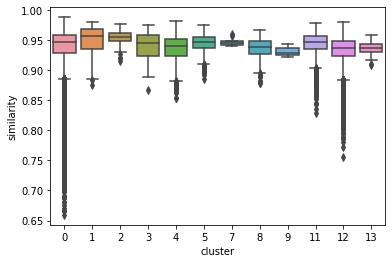

In [39]:
spec_full.plot_consensus_similarity(mode="spectra")

In [20]:
spec.segment(method="WPGMA", number_of_regions=15)

2020-07-06 21:13:24,284  SpectraRegion  INFO: Calculating clusters
I0706 21:13:24.284343 139942458099520 segment.py:1038] Calculating clusters
2020-07-06 21:13:24,612  SpectraRegion  INFO: Calculating clusters done
I0706 21:13:24.612197 139942458099520 segment.py:1053] Calculating clusters done
2020-07-06 21:13:24,620  SpectraRegion  INFO: Calculating clusters saved
I0706 21:13:24.620660 139942458099520 segment.py:1071] Calculating clusters saved


array([[3, 3, 3, ..., 2, 2, 3],
       [3, 3, 3, ..., 2, 3, 3],
       [3, 3, 3, ..., 2, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int16)

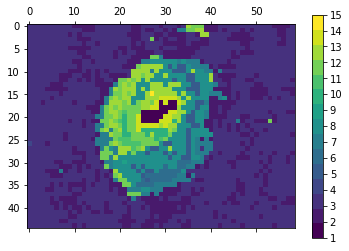

In [21]:
spec.plot_segments()

In [26]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

2020-07-06 21:18:35,287  SpectraRegion  INFO: Assigning clusters to background: {2, 3}
I0706 21:18:35.287949 139942458099520 segment.py:1160] Assigning clusters to background: {2, 3}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

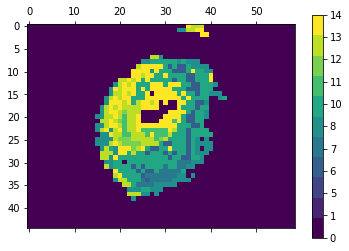

In [27]:
spec.plot_segments()

In [ ]:
spec.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

In [ ]:
mpl.rcParams['figure.figsize'] = (10,6)
spec.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

In [ ]:
spec.plot_segments()

In [ ]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

In [ ]:
spec.plot_segments()

In [34]:
spec.consensus_spectra()

2020-07-06 21:24:55,442  SpectraRegion  INFO: Calculating consensus spectra
I0706 21:24:55.442516 139942458099520 segment.py:1214] Calculating consensus spectra
2020-07-06 21:24:55,582  SpectraRegion  INFO: Calculating consensus spectra done
I0706 21:24:55.582017 139942458099520 segment.py:1226] Calculating consensus spectra done


{0: array([0.3293662 , 0.3293662 , 0.3293662 , ..., 1.17205396, 1.08523585,
        1.00221622]),
 13: array([0.30996149, 0.30996149, 0.30996149, ..., 0.44690438, 0.43266794,
        0.4117067 ]),
 12: array([0.35382338, 0.35382338, 0.35382338, ..., 0.52657818, 0.50807417,
        0.49093822]),
 7: array([0.24930137, 0.24930137, 0.24930137, ..., 1.0954698 , 1.01701639,
        0.94086259]),
 8: array([0.27301585, 0.27301585, 0.27301585, ..., 0.53036895, 0.50332405,
        0.47396496]),
 5: array([0.34673055, 0.34673055, 0.34673055, ..., 0.46430838, 0.43402191,
        0.40585365]),
 14: array([0.40354644, 0.40354644, 0.40354644, ..., 0.23584363, 0.22765709,
        0.22839505]),
 1: array([0.4306265 , 0.4306265 , 0.4306265 , ..., 0.20435403, 0.20276101,
        0.20359243]),
 11: array([0.38772242, 0.38772242, 0.38772242, ..., 0.31617803, 0.31580472,
        0.30957355]),
 10: array([0.51663011, 0.51663011, 0.51663011, ..., 0.32015983, 0.30868474,
        0.29706513]),
 6: array([0.41

In [35]:
spec.consensus_similarity()

2020-07-06 21:25:05,079  SpectraRegion  INFO: Found clusterLabels [0, 1, 5, 6, 7, 8, 10, 11, 12, 13, 14]
I0706 21:25:05.079781 139942458099520 segment.py:1344] Found clusterLabels [0, 1, 5, 6, 7, 8, 10, 11, 12, 13, 14]
2020-07-06 21:25:05,084  SpectraRegion  INFO: Processing clusterLabel 0
I0706 21:25:05.084406 139942458099520 segment.py:1352] Processing clusterLabel 0
2020-07-06 21:31:12,306  SpectraRegion  INFO: Processing clusterLabel 1
I0706 21:31:12.306190 139942458099520 segment.py:1352] Processing clusterLabel 1
2020-07-06 21:31:12,347  SpectraRegion  INFO: Processing clusterLabel 5
I0706 21:31:12.347161 139942458099520 segment.py:1352] Processing clusterLabel 5
2020-07-06 21:31:12,564  SpectraRegion  INFO: Processing clusterLabel 6
I0706 21:31:12.564101 139942458099520 segment.py:1352] Processing clusterLabel 6
2020-07-06 21:31:12,627  SpectraRegion  INFO: Processing clusterLabel 7
I0706 21:31:12.627329 139942458099520 segment.py:1352] Processing clusterLabel 7
2020-07-06 21:31

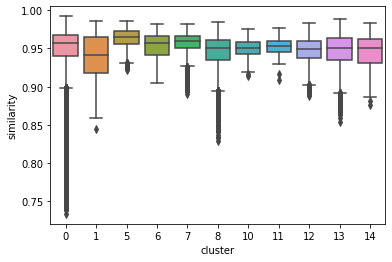

In [36]:
spec.plot_consensus_similarity(mode="spectra")

In [ ]:
avg_spec.shape

In [ ]:
speaks.shape

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(range(0,len(avg_spec)), avg_spec)
plt.scatter(mzvals, avg_spec[mzvals], c='r')

In [ ]:
res = calc_similarity(speaks)

In [ ]:
simMat = res[0] / np.max(res[0])

In [ ]:
spec.spectra_similarity = simMat

In [ ]:
spec.segment(method="WARD", number_of_regions=15)

In [ ]:
spec.plot_segments()

In [ ]:
testra = np.zeros((2,2,10))
testra[0,0] = [1,1,1,1,1,0,0,0,0,0]
testra[0,0] = [1,1,1,1,1,0,0,0,0,0]
testra[0,0] = [1,1,1,1,1,0,0,0,0,0]
testra[0,0] = [1,1,1,1,1,0,0,0,0,0]

In [ ]:
testspec = SpectraRegion( testra, [1,2,3,4,5,6,7,8,9,10])

In [ ]:
testra.shape

In [ ]:
testspec.calc_similarity(testra)